# Project Notebook: Chess Puzzle EDA and Feature Engineering

### This notebook will:
### 1. Load the `puzzles.csv` file. And sample the large data.
### 2. Engineer features from the 'FEN' string factor.
### 3. Perform initial EDA on the new features and the 'Rating' target.
### 4. Engineer the classification target 'difficulty_2n' categories.


### i. Import Libraries

In [2]:

#Libraries
import pandas as pd # for data manipulation and analysis
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
import chess  # for chess board representation and manipulation



## 1. Load the Dataset
### Loading the main CSV and take a smaller sample for faster development.

In [ ]:
# Load data and get shape
df_full = pd.read_csv('puzzles.csv') # change path as needed
print(f"Full dataset loaded. Shape: {df_full.shape}")

Full dataset loaded. Shape: (5423662, 11)


##### Create a smaller sample for development (@50,000 puzzles);
##### The full dataset (5.4M+ rows) is too large to process quickly.

In [ ]:
# sample.  
df = df_full.sample(n=50000, random_state=42).copy()
# new shape, head, and columns
print(f"Using a sample of 50,000 puzzles. Shape: {df.shape}")
print(df.head())
df.columns

Using a sample of 50,000 puzzles. Shape: (50000, 11)
        PuzzleId                                                FEN  \
3597565    f9PQx  6k1/p5pp/n3qp2/1p6/1b1N1QN1/7P/PBp2PP1/5rK1 w ...   
2430250    RmvPy  r2q1rk1/p1p2ppp/2pn4/3p4/5Pb1/1P1PP1R1/PBP3PP/...   
4977447    uu1eQ  r5r1/1bb1k2p/p2qpp1B/1p6/2pPB3/2P5/PP2QRPP/4R1...   
2061301    NZNGr  5rk1/pp3ppp/2brpn2/q3P3/4P3/1B5P/PP1NQ1P1/3R1R...   
2262607    PsA2z         8/5p2/4p1p1/1P4K1/5P2/6kp/8/3B4 w - - 0 43   

                                 Moves  Rating  RatingDeviation  Popularity  \
3597565                      g1f1 e6e1     998               82          79   
2430250  g4d1 g3g7 g8h8 g7f7 h8g8 f7g7    1756               76          89   
4977447            e4b7 d6h2 g1f1 h2h1     986               81          83   
2061301            a5e5 d2c4 e5e4 e2e4    1374               75          94   
2262607            b5b6 h3h2 d1f3 g3f3    1050               77          87   

         NbPlays                             

Index(['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity',
       'NbPlays', 'Themes', 'OpeningTags', 'PuzzleUrl', 'GameUrl'],
      dtype='object')

## 2. Feature Engineering
### Parse the 'FEN' string.   
See: https://github.com/niklasf/python-chess

In [ ]:

# Define piece values
piece_values = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9,
    chess.KING: 0 # Kings have no material value
}
#functions for new categories that may tip favor for the puzle to be solved/check mated.
def parse_fen_features(fen):
    """
    Parses a FEN string and extracts numerical features.
    """
    try:
        board = chess.Board(fen)
    except ValueError:
        # Handle rare cases of invalid FENs
        return pd.Series([np.nan] * 5, index=['material_diff', 'total_material', 'is_check', 'white_piece_count', 'black_piece_count'])

    white_material = 0
    white_piece_count = 0
    black_material = 0
    black_piece_count = 0

    # Get all piece locations
    piece_map = board.piece_map()
    
    for square, piece in piece_map.items():
        value = piece_values.get(piece.piece_type, 0)
        
        if piece.color == chess.WHITE:
            white_material += value
            white_piece_count += 1
        else:
            black_material += value
            black_piece_count += 1

    # Calculate material difference from the *current player's* perspective
    # board.turn == chess.WHITE means it's White's turn to move
    if board.turn == chess.WHITE:
        material_diff = white_material - black_material
    else:
        material_diff = black_material - white_material
        
    total_material = white_material + black_material
    is_check = 1 if board.is_check() else 0  # if the solver is forced to defend from check, forcing a move, rather than less obvious choices.

    return pd.Series([material_diff, total_material, is_check, white_piece_count, black_piece_count], 
                     index=['material_diff', 'total_material', 'is_check', 'white_piece_count', 'black_piece_count'])


# Apply the function to the FEN column

# Use .join() to add the new columns to the DataFrame
df = df.join(df['FEN'].apply(parse_fen_features))

# Drop any rows that failed to parse
df.dropna(subset=['material_diff'], inplace=True)

print("Feature engineering complete.")
print(df.head()) # scroll to see new columns



Feature engineering complete.
        PuzzleId                                                FEN  \
3597565    f9PQx  6k1/p5pp/n3qp2/1p6/1b1N1QN1/7P/PBp2PP1/5rK1 w ...   
2430250    RmvPy  r2q1rk1/p1p2ppp/2pn4/3p4/5Pb1/1P1PP1R1/PBP3PP/...   
4977447    uu1eQ  r5r1/1bb1k2p/p2qpp1B/1p6/2pPB3/2P5/PP2QRPP/4R1...   
2061301    NZNGr  5rk1/pp3ppp/2brpn2/q3P3/4P3/1B5P/PP1NQ1P1/3R1R...   
2262607    PsA2z         8/5p2/4p1p1/1P4K1/5P2/6kp/8/3B4 w - - 0 43   

                                 Moves  Rating  RatingDeviation  Popularity  \
3597565                      g1f1 e6e1     998               82          79   
2430250  g4d1 g3g7 g8h8 g7f7 h8g8 f7g7    1756               76          89   
4977447            e4b7 d6h2 g1f1 h2h1     986               81          83   
2061301            a5e5 d2c4 e5e4 e2e4    1374               75          94   
2262607            b5b6 h3h2 d1f3 g3f3    1050               77          87   

         NbPlays                                             Themes 

In [19]:
df.columns

Index(['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity',
       'NbPlays', 'Themes', 'OpeningTags', 'PuzzleUrl', 'GameUrl',
       'material_diff', 'total_material', 'is_check', 'white_piece_count',
       'black_piece_count'],
      dtype='object')

## 3. Exploratory Data Analysis (EDA) on New Data


Plotting distribution of 'Rating' (our target)...


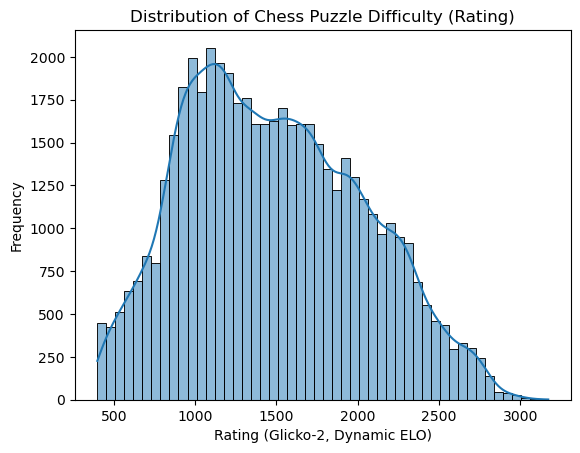


Plotting correlation of new features vs. Rating...


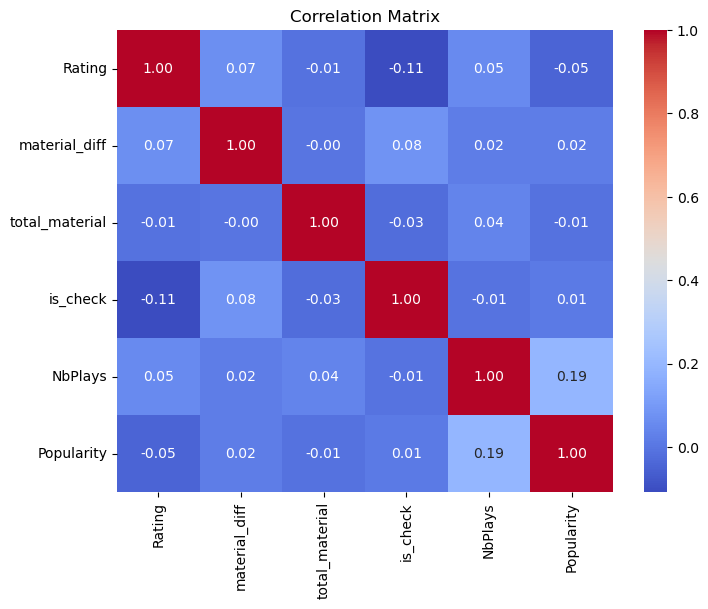

In [9]:
# Plot the distribution of the target variable: Rating
print("\nPlotting distribution of 'Rating' (our target)...")
sns.histplot(df['Rating'], kde=True, bins=50)
plt.title('Distribution of Chess Puzzle Difficulty (Rating)')
plt.xlabel('Rating (Glicko-2, Dynamic ELO)')
plt.ylabel('Frequency')
plt.show()

# Plot the correlation between the new features and the Rating
print("\nPlotting correlation of new features vs. Rating...")
features_to_correlate = ['Rating', 'material_diff', 'total_material', 'is_check', 'NbPlays', 'Popularity']
corr_matrix = df[features_to_correlate].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


##### A right skewed distribuion how hat the harder puzzles are more rare. 
##### Surprisingly low correlations, only -11% for opposition being in check 7% for material differnece. 5% for plays, -5% for popularity, and -1% for total material!  Definately not a linear situation.

## 4. Engineer Classification Target ('difficulty_2n')
### For trees and SVM, we need a classification target.

In [10]:
# Define difficulty based on the Rating
# We can use quantiles (3 equal groups) or fixed values
# Using fixed values for interpretability
bins = [
    0,      # Min
    1200,   # Easy
    1800,   # Medium
    3000    # Hard (max rating)
]
labels = ['Easy', 'Medium', 'Hard']

df['difficulty_2n'] = pd.cut(df['Rating'], bins=bins, labels=labels, right=False)

print("\nDistribution of new 'difficulty_2n' target:")
print(df['difficulty_2n'].value_counts(normalize=True))





Distribution of new 'difficulty_2n' target:
difficulty_2n
Easy      0.355339
Medium    0.352699
Hard      0.291962
Name: proportion, dtype: float64


As witnessed in the distribution plot.

### Next Steps
#
### The data is now ready for modeling!
#
### 1.  **Regression:** Use `material_diff`, `total_material`, `is_check` (and `Themes`) to predict `Rating`.
### 2.  **Classification:** Use the same features to predict `difficulty_2n`.
### 3.  **Unsupervised:** Use K-Means on the features to find puzzle "types".
#
### This data is clean, stable, and ready for statistical learning models.